<a href="https://colab.research.google.com/github/RileyWClarke/MLTSA_RClarke/blob/master/HW4/rclarke_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLTSA - Riley Clarke - HW4

In [0]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
%matplotlib inline

In [0]:
plt.style.use("https://raw.githubusercontent.com/fedhere/MLTSA_FBianco/master/fbb.mplstyle")

In [3]:
!pip install emcee
!pip install corner

     |████████████████████████████████| 51kB 2.4MB/s 
  Created wheel for corner: filename=corner-2.0.1-cp36-none-any.whl size=11642 sha256=53cf268e70aff2833f588fc9d7c7a10425311d0791eb4c1651c2c8c25eb5d694
  Stored in directory: /root/.cache/pip/wheels/70/d8/e5/e0e7974a2a5757483ea5a180c937041cf6872dc9993d78234a
Successfully built corner


In [0]:
import emcee
import corner
import scipy.optimize as op
from corner import hist2d

In [0]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def line(x, slope, intercept):
    """ creates a line 
    x: exogenous variable
    slope: slope line parameter
    intercept: intercept line parameter
    """
    return x * slope + intercept


Run the cells of code below until you reach the assignment cell. This will read in data and run simpler models that you can look at to help yourself creating the one in the assignment

# Data Read-in

In [6]:
data = pd.read_csv("https://raw.githubusercontent.com/fedhere/MLTSA_FBianco/master/HW4/table1.dat",
                   sep=" ")
data.head()

,x,y,sy,sx,rxy
0,201,592,61,9,-0.84
1,244,401,25,4,0.31
2,47,583,38,11,0.64
3,287,402,15,7,-0.27
4,203,495,21,5,-0.33


In [0]:
nall = len(data)
n = nall - 5

findfont: Font family ['["sans-serif"]'] not found. Falling back to DejaVu Sans.


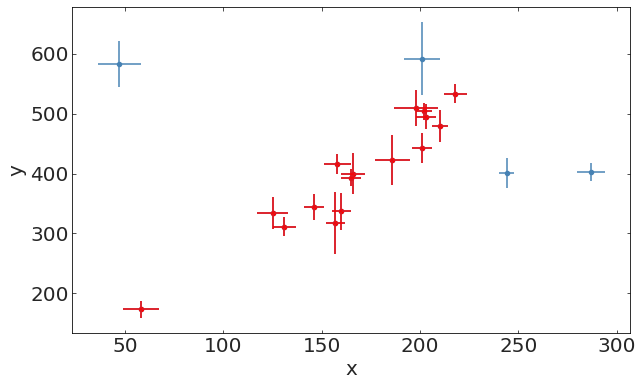

In [8]:
ax = data.plot(x='x', y="y", yerr="sy", xerr="sx", kind="scatter");
data[4:].plot(x='x', y="y", yerr="sy", xerr="sx", kind="scatter", ax=ax, color='r');

Fig 1: All data from https://arxiv.org/pdf/1008.4686.pdf: data in red is the code dataset, data in blue are presumed outliers

# get the initial guess by somple polynomial fitting to the restricted dataset

Initial Guess:
Slope = 2.216656024264677
Intercept = 28.843451929600416


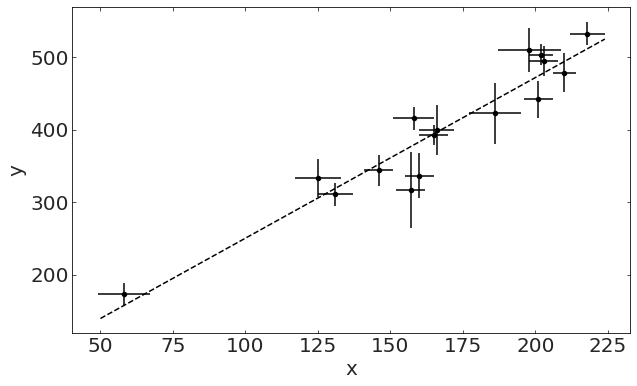

In [9]:
rdata = data[4:]
ax = rdata.plot(x='x', y="y", yerr="sy", xerr="sx", color='k', kind="scatter")
pars = np.polyfit(rdata.x, rdata.y, 1)
dom = np.arange(50,225)
plt.plot(dom, line(dom, pars[0], pars[1]), c='k', ls='--')
print('Initial Guess:')
print("Slope = {}".format(pars[0]))
print("Intercept = {}".format(pars[1]))

Figure 1.5: The polynomial best fit against the reduced version of the data shown in Figure 1

## MCMC

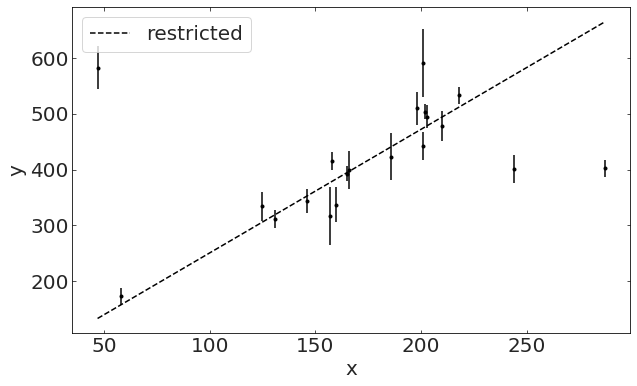

In [10]:
xx = np.arange(data.x.min(), data.x.max(), 0.1)
plt.errorbar(data.x, data.y, data.sy, fmt='.',  color='k')
plt.plot(xx, line(xx, pars[0], pars[1]), 'k--', label="restricted")
plt.xlabel("x")
plt.ylabel("y")
plt.legend();

Fig 2: the polynomial best fit obtained with numpy.polyfit() overplotted to the dataset in Figure 1.

In [0]:
#define a log likelihood that includes 
# - parameters slope and intercept (m, b), 
# - the probability that the point is an outlier Pb 
# - and a distribution fo the outliers, parameters (Yb, Vb), the mean and variance of the distribution of outliers

def lnlike(theta, x, y, yerr):
    '''log likelihood
    theta: 5 parameters vector, see prior for details,
    x: exogenous vextor
    y: endoogenous vector
    yerr: uncertainties vector
    '''
    
    m, b = theta
    #line fit model
    model = m * x + b
    #variance of data
    sig2 = yerr**2
    
    #normalization: this is importnat because we have 2 linearly combined pieces of model
    den = 2 * np.pi * sig2
    
    #this is the probability that the point comes from the line
    a = (1) / np.sqrt(den) *\
        np.exp(-(y-model)**2 /  2.0 / sig2)   
    return  np.sum(np.log(a))

In [0]:
def lnprior(theta):
    '''
    logprior on the parameters theta
    theta: 5 parameter vector: slpoe, intercept, 
                                Yb mean of the process that creates the outliers,
                                Pb probability that a point is an outlier,
                                V the variance of the process that generates outliers
    '''
    m, b = theta
    if -200 < b < 500 and 0 < m < 10.0 :
        #Pb is a probability so it is bound to 0-1
        return 0.0
    
    return -np.inf

def lnprob(theta, x, y, yerr):
    ''' log likelihood * log prior: the posterior
    '''
    lp = lnprior(theta)
    
    if not np.isfinite(lp) :
        return -np.inf
    lnl = lnlike(theta, x, y, yerr)
    if  np.isnan(lnl):
        return -np.inf
    return lp + lnl 

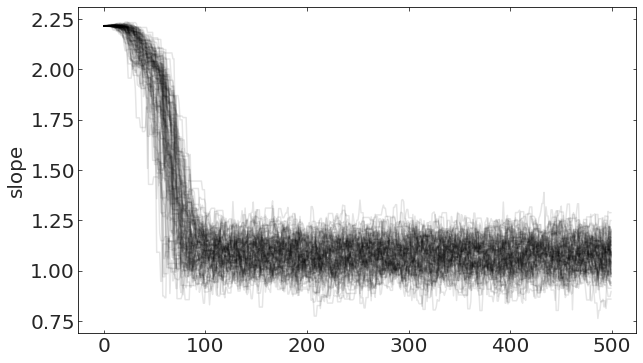

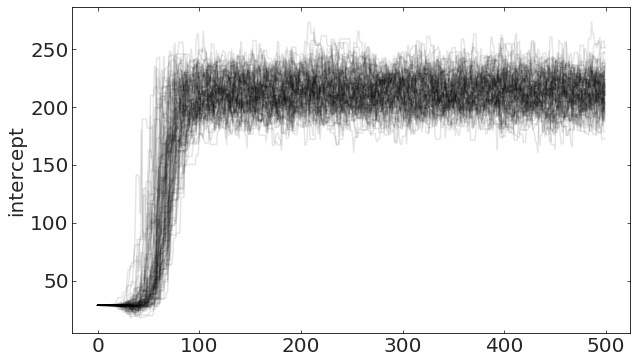

In [0]:
ndim, nwalkers = 2, 100 # number of variables optimized over, number of walkers per variable
init = np.hstack([pars[0], pars[1]]) # initialize the variable at a single point with some noise
pos = [init + 
       init * 1e-4 * np.random.randn(ndim) for i in range(nwalkers)] #  
sampler = emcee.EnsembleSampler(nwalkers, ndim, 
                                lnprob, 
                                args=(data.x, data.y,
                                     data.sy))
sampler.run_mcmc(pos, 500);
labels = ["slope", "intercept","Yb mean of the process that creates the outliers",
               "Pb probability that a point is an outlier",
                 "V" ]
for i in range(ndim):
    plt.figure()
    for j in range(100): 
        plt.plot(sampler.chain[j,:,i], 'k', alpha=0.1)
    plt.ylabel(labels[i])
        
        
burnout = 150
samples = sampler.chain[:, burnout:, :].reshape((-1, ndim))

Fig 3: The walkers chains obtained from the ```emcee``` implementation of the affine invariant algorithm https://emcee.readthedocs.io/en/stable/

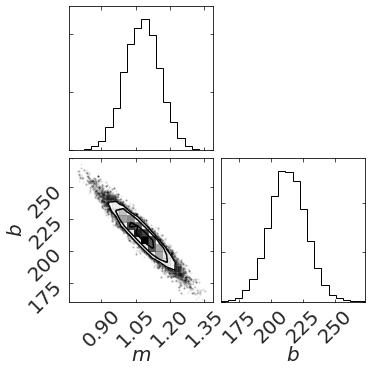

In [0]:
fig = corner.corner(samples, 
                        labels=["$m$", "$b$", "Y", r"$P_b$", "V"],
                        truths=init)
m_mcmc, b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples[:,:2], [16, 50, 84],
                                                axis=0)))

Figure 4: Corner plot of the MCMC samples shown in Figure 3. A corner plot is used to visualize multidimensional samples of the parameter space using a scatterplot matrix. The intersection of two parameters in the matrix is a 2D histogram of posterior samples, which is a 2D slice of the N-dimensional parameter space. These can be useful in  revealing covariance between the parameters, as is the case with the parameters m & b in the above figure. The intersection of any parameter with itself is a 1D histogram of the samples of that parameter.

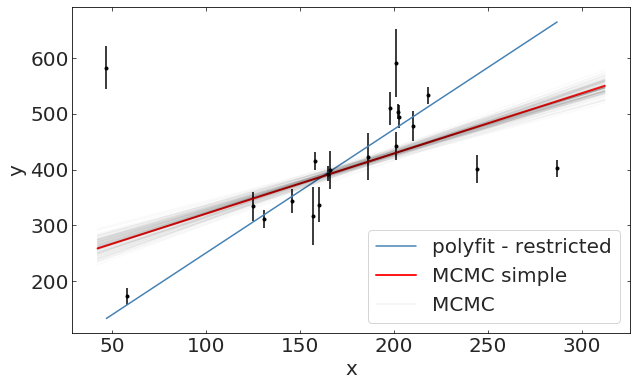

In [0]:
xl = np.arange(data.x.min() * 0.9, data.x.max() * 1.1, 10)
plt.errorbar(data.x, data.y, yerr=data.sy, fmt=".k")
plt.plot(xx, line(xx, pars[0], pars[1]), '-', label="polyfit - restricted")
plt.plot(xl, line(xl, m_mcmc[0], b_mcmc[0]), color="r", lw=2, 
        alpha=0.9, label="MCMC simple")
for m, b in samples[np.random.randint(len(samples), size=100)][:,:2]:
    plt.plot(xl, m*xl+b, color="k", alpha=0.02)
plt.plot(xl, m*xl+b, color="k", alpha=0.05, label="MCMC")
plt.legend();
plt.xlabel("x")
plt.ylabel("y")
plt.legend();

Fig 5: Same as Figure 2 with the results of the MCMC best fit to the sample likelihood equation derived from tha assumption of a line generative process with Gaussian uncertainties. In red is the median value of the parameters slope and intercept optained with a 100 walkers over a 500 steps chain (removing a 150 points burn-in region) and in gray are random samples from the parameter distributions. 

The line fit diverges significantly from the original polynomial fit due to the inclusion of outlier points in the dataset. 

In [0]:
#define a log likelihood that includes 
# - parameters slope and intercept (m, b), 
# - the probability that the point is an outlier Pb 
# - and a distribution fo the outliers, parameters (Yb, Vb), the mean and variance of the distribution of outliers

def lnlike(theta, x, y, yerr):
    '''log likelihood
    theta: 5 parameters vector, see prior for details,
    x: exogenous vextor
    y: endoogenous vector
    yerr: uncertainties vector
    '''
    
    m, b, Yb, Pb, V = theta
    #line fit model
    model = m * x + b
    #variance of data
    sig2 = yerr**2
    
    #normalization: this is importnat because we have 2 linearly combined pieces of model
    den = 2 * np.pi * sig2
    
    #this is the probability that the point comes from the line
    linelik = (1 - Pb) / np.sqrt(den) *\
        np.exp(-(y-model)**2 /  2.0 / sig2)  
    #this is the probability that it does not
    gausslik = Pb / np.sqrt(den + 2*np.pi*V) *\
        np.exp (-(y - Yb)**2 / 2 / (V + sig2))
    return  np.sum(np.log(linelik + gausslik))

In [0]:
def lnprior(theta):
    '''
    logprior on the parameters theta
    theta: 5 parameter vector: slpoe, intercept, 
                                Yb mean of the process that creates the outliers,
                                Pb probability that a point is an outlier,
                                V the variance of the process that generates outliers
    '''
    m, b, Yb, Pb, V = theta
    if -200 < b < 500 and 0 < m < 10.0 :
        #Pb is a probability so it is bound to 0-1
        if Pb < 0 or Pb > 1:
            return -np.inf
        # set some constraints on the mean of the process that creates the outliers
        if  Yb > ymean + 150 or Yb < ymean - 150:
            return -np.inf

        if V < 0:
            return -np.inf
        #print("3")
        return 0.0
    
    return -np.inf

def lnprob(theta, x, y, yerr):
    ''' log likelihood * log prior: the posterior
    '''
    lp = lnprior(theta)
    
    if not np.isfinite(lp) :
        return -np.inf
    lnl = lnlike(theta, x, y, yerr)
    if  np.isnan(lnl):
        return -np.inf
    return lp + lnl 

In [0]:
ymean = data.y.mean()
#initialize from the restricted problem LA solution 


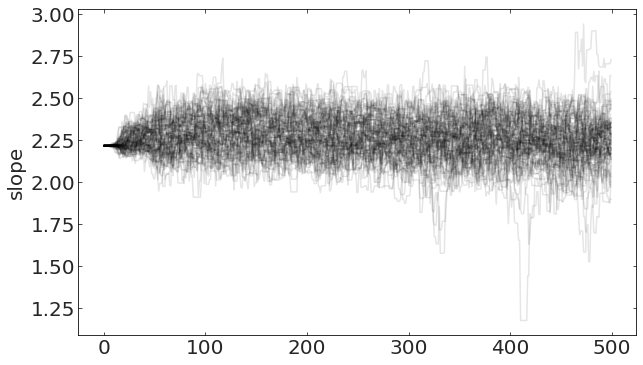

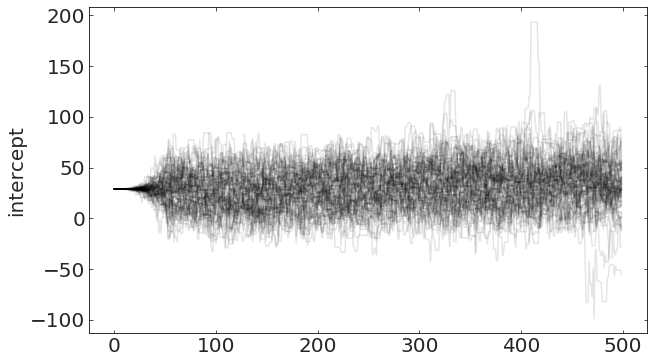

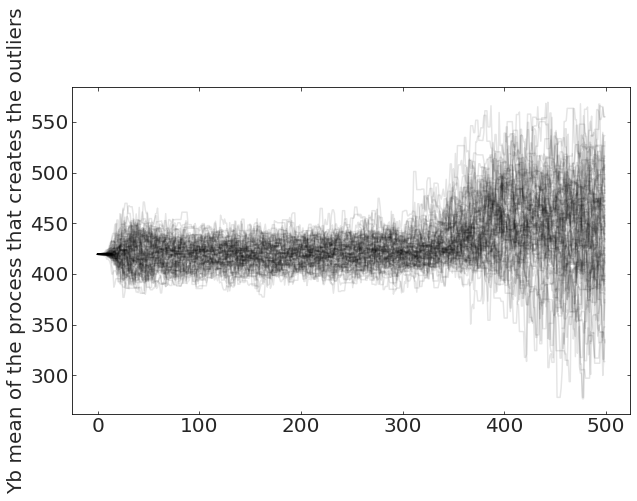

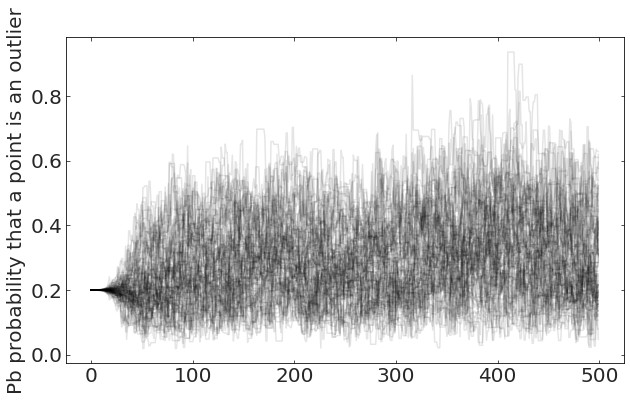

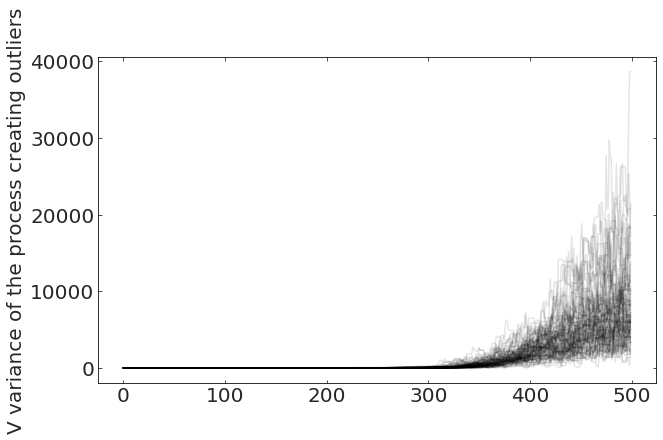

In [0]:
ndim, nwalkers = 5, 100 # number of variables optimized over, number of walkers per variable
init = np.hstack([pars[0], pars[1], ymean, 
                  0.2, 0.1]) # initialize the variable at a single point with some noise
pos = [init + 
       init * 1e-4 * np.random.randn(ndim) for i in range(nwalkers)] #  
sampler = emcee.EnsembleSampler(nwalkers, ndim, 
                                lnprob, 
                                args=(data.x, data.y,
                                     data.sy))
sampler.run_mcmc(pos, 500);
labels = ["slope", "intercept","Yb mean of the process that creates the outliers",
               "Pb probability that a point is an outlier",
                 "V variance of the process creating outliers" ]
for i in range(ndim):
    plt.figure()
    for j in range(100): 
        plt.plot(sampler.chain[j,:,i], 'k', alpha=0.1)
    plt.ylabel(labels[i])
        
        
burnout = 150
samples = sampler.chain[:, burnout:, :].reshape((-1, ndim))

Fig 6: same as figure 3 for the parameters of a model tha includes the probability of a Gaussian generative porcess contaminating the dataset generated by a line-generating process (with added Gaussian noise). The added parameters, added to slope and intercept, are the mean and variance of the Gaussian generative process, and the probability that a point is generated by the extraneous provess (not the line) this model is obtained by marginalizing over all datapoints in the set a complete model that includes the individual probability of being generated bu the extraneous process for each datapoint. 

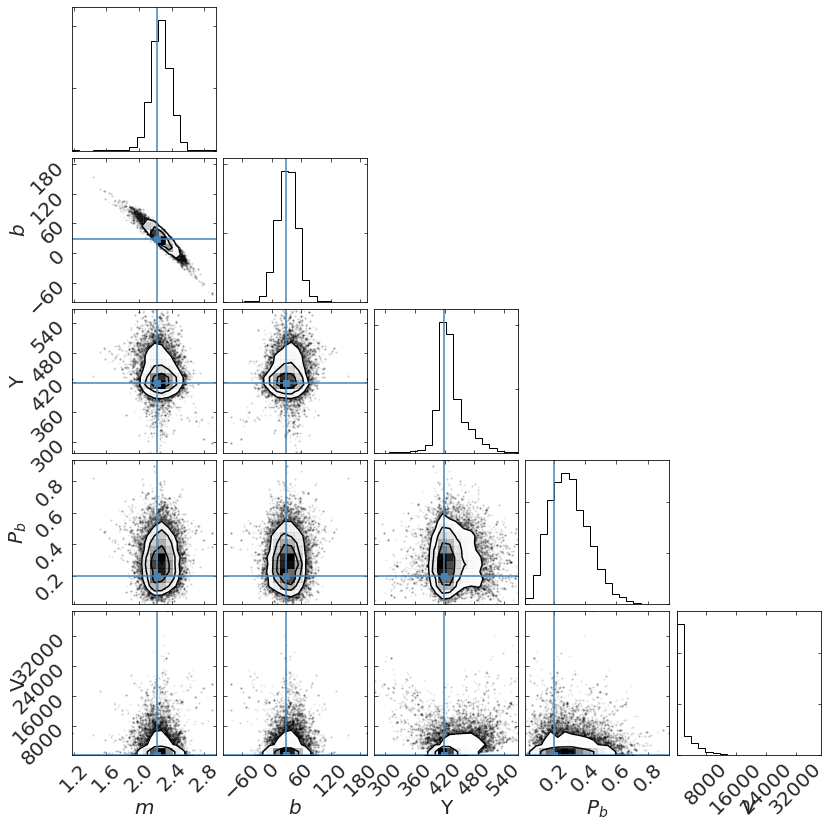

In [0]:
fig = corner.corner(samples, 
                        labels=["$m$", "$b$", "Y", r"$P_b$", "V"],
                        truths=init)
m_mcmc, b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples[:,:2], [16, 50, 84],
                                                axis=0)))

Figure 7: Corner plot for the $L = p(\{y_i\}_{i=1}^{N}|m,b,P_b,Y,V)$ likelihood function. As before, m & b are highly covariant. All parameters appear to span the likelihood space effectively, since all the distributions have roughly the same morphology, though there are some curious asymmetries in some histograms, such as $P_b$ vs $Y$, suggesting the likelihood function may have had multiple minima in the same vicinity for those parameters.

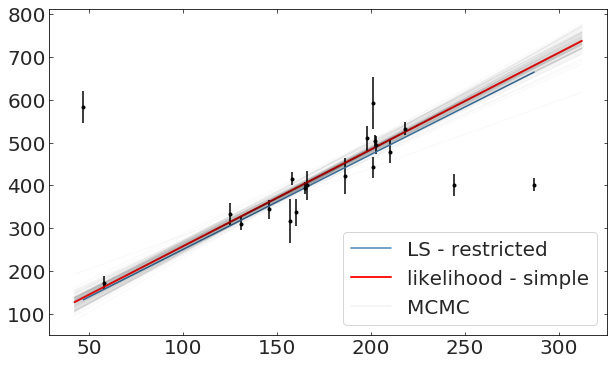

In [0]:
xl = np.arange(data.x.min() * 0.9, data.x.max() * 1.1, 10)
plt.errorbar(data.x, data.y, yerr=data.sy, fmt=".k")
plt.plot(xx, line(xx, pars[0], pars[1]), '-', label="LS - restricted")
plt.plot(xl, line(xl, m_mcmc[0], b_mcmc[0]), color="r", lw=2, alpha=0.9, label="likelihood - simple")
for m, b in samples[np.random.randint(len(samples), size=100)][:,:2]:
    plt.plot(xl, m*xl+b, color="k", alpha=0.02)
plt.plot(xl, m*xl+b, color="k", alpha=0.05, label="MCMC")
plt.legend();

Figure 8: Dataset from Figure 1 with the np.polyfit best fit line in blue,the posterior samples of the likelihood function in grey, and the line representing the median of the parameters in red. In this figure, the MCMC posteriors approximate the polynomial fit on the restricted dataset far better because our likelihood function included a generative model for outlier points, and minimized over the parameters that would best fit the points not generated by the outlier model.

# Homework:
##  Fit all Ps

In [0]:
x = data.x
y = data.y
ymean = y.mean()
sy = data.sy

In [0]:
def lnpriorP(theta):
    '''
    logprior on the parameters theta
    theta: 4 parameter vector: slope, intercept, 
                                Yb mean of the process that creates the outliers,
                                V variance of probability that a point is an outlier,
    
    '''
    m, b, Q, Y, V = theta

    if not -200 < b < 500:
      return -np.inf

    if not 0.0 < m < 10.0:
      return -np.inf

    if not 0 < Q < 1:
      return -np.inf

    if  Y > ymean + 150 or Y < ymean - 150:
      return -np.inf

    if V < 0:
      return -np.inf 
    
    return 0

In [0]:
def lnlikeP_fg(theta):
    m, b, Q, Y, V = theta
    model = m * x + b
    return -0.5 * (((model - y) / sy) ** 2 + 2 * np.log(sy))

def lnlikeP_bg(theta):
    m, b, Q, Y, V = theta
    var = V + sy**2
    return -0.5 * ((Y - y) ** 2 / var + np.log(var))

In [0]:
def lnprobP(theta):
  '''
  posterior
  theta: the parameters vector. see lnpriorP
  '''

  m, b, Q, Y, V = theta

  lp = lnpriorP(theta)
    
  if not np.isfinite(lp):
      return -np.inf

  p_fg = lnlikeP_fg(theta)
  term1 = p_fg + np.log(Q)

  p_bg = lnlikeP_bg(theta)
  term2 = p_bg + np.log(1-Q)

  l1 = np.sum(term1 + term2)

  return lp + l1

In [0]:
ndim, nwalkers = 5, 32
probsinit = np.array([pars[0],pars[1], 0.5, ymean, 7000])


pos = [probsinit + 
       probsinit * 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]  
       
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprobP)

pos, _, _ = sampler.run_mcmc(pos, 500) #burn-in

sampler.reset()
sampler.run_mcmc(pos, 1500) #main MCMC
        
samples = sampler.flatchain;

(1500, 32)


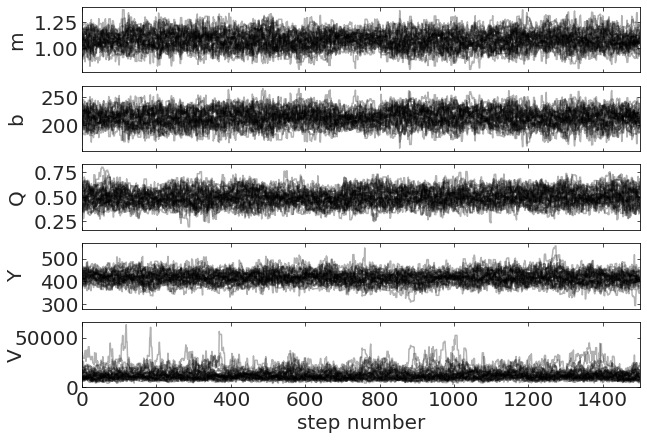

In [30]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
labels = ["m", "b", "Q", "Y", "V"]
sample_chain = np.transpose(sampler.chain)
print(sample_chain[0, :, :].shape)

for i in range(ndim):
    ax = axes[i]
    ax.plot(sample_chain[i, :, :], "k", alpha=0.3)
    ax.set_xlim(0, 1500)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Figure 9: Plot of all 5 walker chains of the mixture model for the line parameters m & b, and the outlier parameters Q (the probability of each point being an outlier), Y (the mean of the outliers), and V (the variance of the outliers).

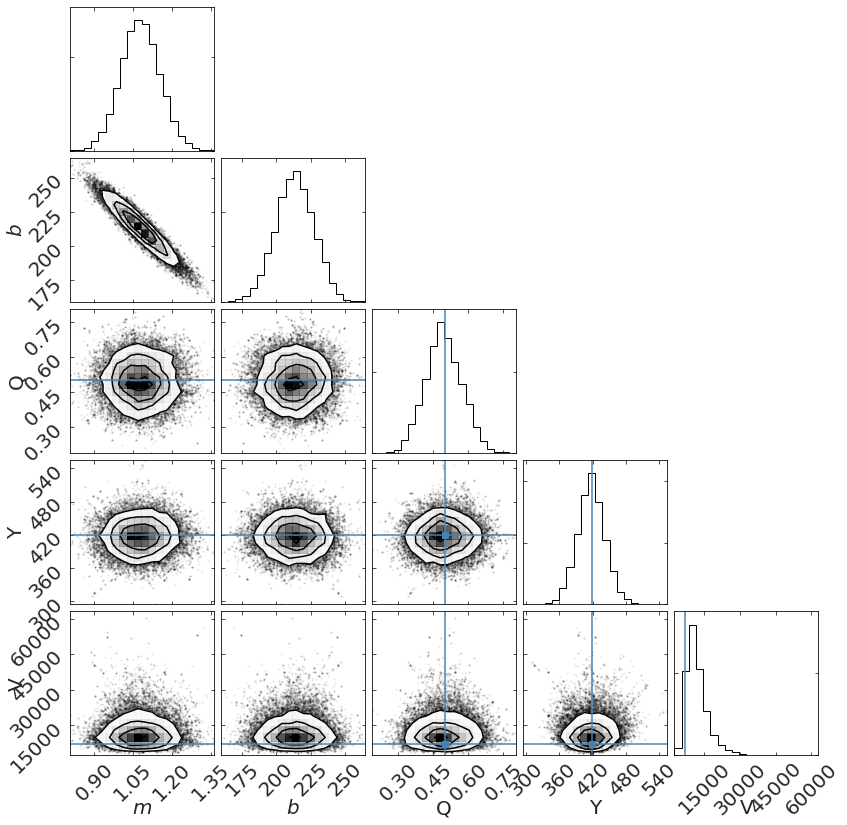

In [36]:
fig = corner.corner(samples, 
                        labels=["$m$", "$b$", "Q", "Y", "V"],
                        truths=probsinit)
m_mcmc, b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples[:,:2], [16, 50, 84],
                                                axis=0)))

Figure 10: Corner plot for the mixture model. We can see from this that the MCMC is converging nicely, although the shape of the V distributions is a bit odd. The thing that concerns me os that the m & b parameters are strongly converging to much different values than those obtained from the polyfit on the reduced set. Not sure why this is happening since this likelihood is modeling the outlier generative process in more or less the same way as earlier.

In [32]:
m_mcmc, b_mcmc

((1.0765861706503363, 0.07630319610765102, 0.07333877771573194),
 (213.35319796047034, 13.892522079805985, 14.006333683617129))

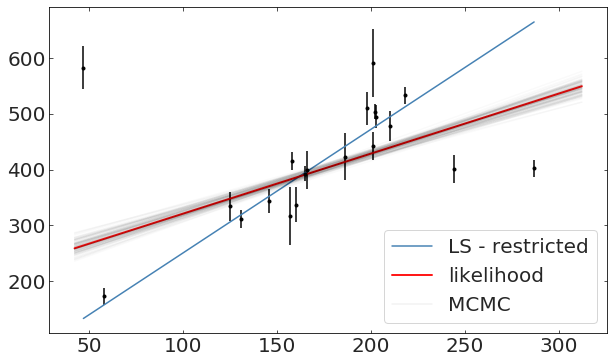

In [33]:
xl = np.arange(x.min() * 0.9, x.max() * 1.1, 10)
x2 = np.arange(x.min(), x.max(), 0.1)
plt.errorbar(x, y, yerr=data.sy, fmt=".k")
plt.plot(x2, line(xx, pars[0], pars[1]), '-', label="LS - restricted")
plt.plot(xl, line(xl, m_mcmc[0], b_mcmc[0]), color="r", lw=2, alpha=0.9, label="likelihood")
for m, b in samples[np.random.randint(len(samples), size=100)][:,:2]:
    plt.plot(xl, m*xl+b, color="k", alpha=0.02)
plt.plot(xl, m*xl+b, color="k", alpha=0.05, label="MCMC")
plt.legend();

Figure 11: In this result, the MCMC posteriors look similar to what was obtained in Figure 5. I'm genuinely confused by this because the likelihood used to generate Figure 5 did not model the outliers at all. Nothing from that section is being passed to the MCMC or to this plot. The issue is probably the way in which I implemented the likelihood function but it should in no way resemble the function that generated figure 5.